### <center> Pneumonia/Lung Disease Prediction/Classification </center>

<b> Problem Statement</b>: In this project we have chest x-ray images of patients with lung disease(pneumonia) and those which do not have lung disease(normal).The aim is to build a convulutional neural network(CNN) model to predict or classify the images into the aforementioned classes and test our model with live data. This model will be served with a Rest API developed in python's FastAPI. Then, React Js and React Native clients will also be developed to consume the API. The dataset utilized in this project can be downloaded here: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download


An Otsogile Ogaisitse Onalepelo aka Morena Project

#### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.models import load_model
from sklearn.metrics import classification_report,roc_curve, auc,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

#### Load the dataset.

Fortunately our dataset is already divided into train, validation and test sets. All we have to do is load them. It is also worth noting that our our images have different dimensions. We have to resize all of them to have the same shape when we load them.

In [2]:
#set constants we are going to use through out in this project
#Size of the batches of data
BATCH_SIZE = 32

#set the size we want for all images: 256*256
IMAGE_SIZE = 256

#refers to the rbg channels: red,blue,green
CHANNELS=3

#number of iterations we want to train our model with. 
EPOCHS= 50

### Import data into the tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
#load the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./dataset/chest_xray/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

#load the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./dataset/chest_xray/val",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

#load the testing dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./dataset/chest_xray/test",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [4]:
train_ds.class_names

['NORMAL', 'PNEUMONIA']

In [5]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [6]:
val_ds.class_names

['NORMAL', 'PNEUMONIA']

In [7]:
test_ds.class_names

['NORMAL', 'PNEUMONIA']

We have two classes: NORMAL and PNEUMONIA present in all our datasets

In [8]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]


As you can see above, each element in the train dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels.

In [9]:
for image_batch, labels_batch in val_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 256, 256, 3)
[0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0]


For the validation dataset we have one batch having 16 instead of images 32. This is because we only have 16 images in the validation directory not 32 as per pur required batch size.

In [10]:
for image_batch, labels_batch in test_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1]


The test dataset is same as the training dataset shapewise.

### Training Set Data Visualization

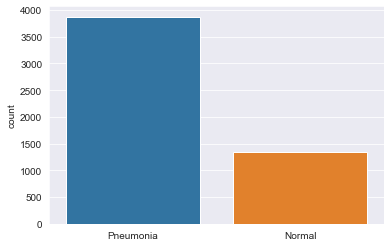

In [11]:
labels = []
for x, y in train_ds:
  #y here is going to be returned as a tensor.Convert each tensor first to a numpy array then loop through it
  for i in y.numpy():
    if(i == 1):
        labels.append("Pneumonia")
    else:
        labels.append("Normal")
        
sns.set_style('darkgrid')
#this is going to emmit a future warning error,ignore it.
sns.countplot(labels)

In [12]:
#count values per class
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{'Normal': 1341, 'Pneumonia': 3875}

There is a class imbalance in our train set. It has more pneumonia images (3875) compared to those which are normal(1341). Nonetheless, I am a bit sluggish right now 😶. So, I am not going to handle this imbalance in the training set. For this model's sake, I really hope this would not be detrimental to our its performance. Well, fingers crossed. 🤞🏻😐

### Visualize some of the images from our training dataset

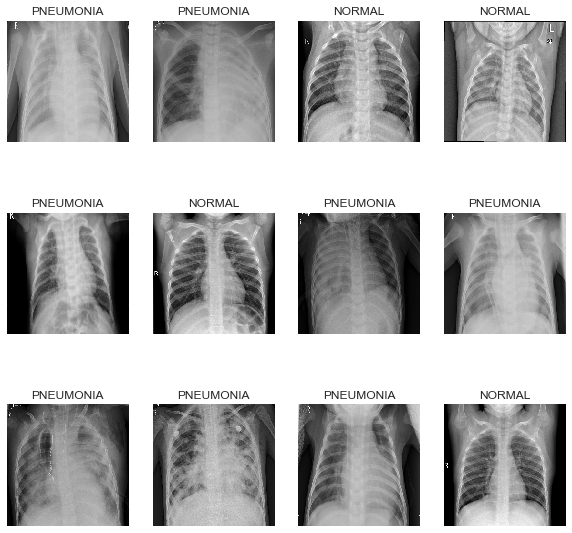

In [13]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Visualize some of the images from our validation dataset

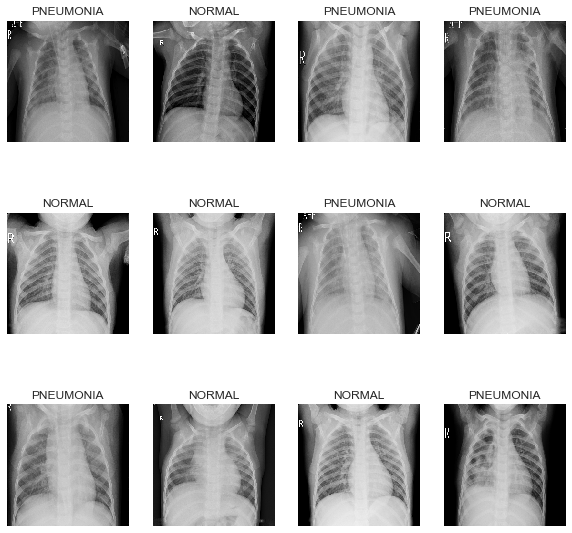

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in val_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Visualize some of the images from our testing dataset

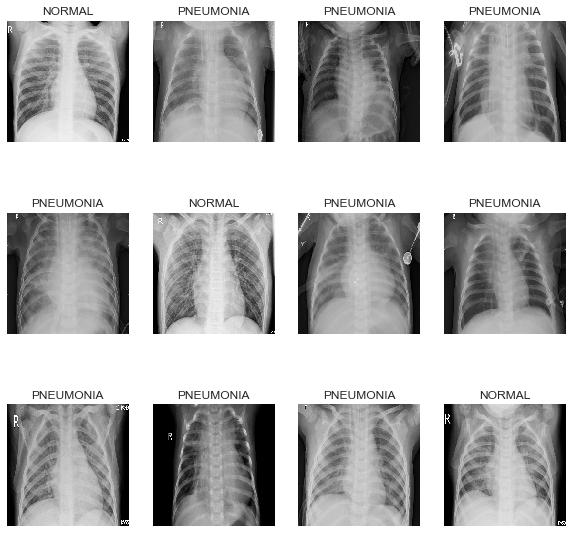

In [15]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Cache, Shuffle, and Prefetch the Dataset

In [16]:
train_ds_1 = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_1 = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_1 = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

##### Creating a Layer for Resizing and Normalization
Before we feed our images to a network, we should resize them to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 255). RGB values range from 0 to 255 hence we are dividing by 255. This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to (256,256) again . You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time someone can supply an image that is not (256,256) and this layer will resize it.

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

#### Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data and it also helps curb overffiting.The reason is that, as we add more data, the model is unable to overfit all the samples, and is forced to generalize.

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.3),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.1,width_factor=0.1),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
])

#### Applying Data Augmentation to Train Dataset

In [19]:
train_ds_2 = train_ds_1.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
We use a CNN coupled with a Sigmoid activation function in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. 

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', strides = 1, padding = 'same', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides = 2, padding = 'same'),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', strides = 1, padding = 'same'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2),strides = 2),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',strides = 1, padding = 'same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides = 2),
    layers.Conv2D(128, (3, 3), activation='relu', strides = 1, padding = 'same'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides = 2),
    layers.Conv2D(256, (3, 3), activation='relu', strides = 1, padding = 'same'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2),strides = 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 256, 256, 32)        896       
                                                                 
 batch_normalization (BatchN  (32, 256, 256, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (32, 128, 128, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 128, 128, 64)        18496     
                                                                 
 dropout (Dropout)           (32, 128, 128, 64)       

### Compiling the Model

We use adam Optimizer, BinaryCrossentropy for losses, accuracy as a metric

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

### Model Callbacks

In [23]:
#learning rate callback
reduce_lr_callback =  tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=1,
    verbose=1,
    min_lr=0.000001
)

#early stoping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1
)

#checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'pneumonia_prediction_best_model.h5',
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

model_callbacks = [early_stopping_callback,reduce_lr_callback,checkpoint_callback]

In [24]:
history = model.fit(
    train_ds_2,
    batch_size=BATCH_SIZE,
    validation_data=val_ds_1,
    verbose=1,
    epochs=EPOCHS,
    callbacks = model_callbacks
)

Epoch 1/50
163/163 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.8391
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to pneumonia_prediction_best_model.h5
163/163 [==============================] - 1473s 9s/step - loss: 0.5275 - accuracy: 0.8391 - val_loss: 8.1839 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
163/163 [==============================] - ETA: 0s - loss: 0.2659 - accuracy: 0.8911
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 00002: val_accuracy did not improve from 0.50000
163/163 [==============================] - 1530s 9s/step - loss: 0.2659 - accuracy: 0.8911 - val_loss: 8.6920 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
163/163 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9118
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 00003: val_accuracy did not improve from 0.50000
163/163 [==============================]

In [25]:
# load the saved model
saved_model = load_model('pneumonia_prediction_best_model.h5')

In [26]:
scores = saved_model.evaluate(test_ds_1)

20/20 [==============================] - 42s 2s/step - loss: 0.5083 - accuracy: 0.8237


With reduce learning rate min learning rate set to 0.000001 we get around 74% accuracy. when we use dropout regularization and within layers batch normalization we get around 82% accuracy but with the prior changed model architecture we get around 84%. Therefore, we will stop training and experimenting with our model here. You can see below that we get around 85.25% accuracy for our test dataset. This is considered to be a pretty good accuracy.

In [27]:
scores

[0.5082785487174988, 0.8237179517745972]

Scores is just a list containing loss and accuracy values

### Plotting the Accuracy and Loss Curves

In [28]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 163}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

#### loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [31]:
type(history.history['loss'])

list

In [32]:
len(history.history['loss'])

19

In [33]:
#show loss for first 5 epochs
history.history['loss'][:5] 

[0.5274965167045593,
 0.2659132480621338,
 0.21873830258846283,
 0.20503166317939758,
 0.1994376927614212]

Our model was actually doing a great job at minimising the objective function or loss. As its evident from the above that it decreased at each iteration or epoch

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [35]:
acc

[0.839148759841919,
 0.8911042809486389,
 0.9118098020553589,
 0.9194785356521606,
 0.9225460290908813,
 0.9246549010276794,
 0.9236963391304016,
 0.9254217743873596,
 0.9254217743873596,
 0.9219708442687988,
 0.9215874075889587,
 0.9233129024505615,
 0.9235045909881592,
 0.9279140830039978,
 0.9279140830039978,
 0.9258052110671997,
 0.9242714643478394,
 0.9244632124900818,
 0.9244632124900818]

In [36]:
val_acc

[0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.625,
 0.625,
 0.625,
 0.5625,
 0.5625,
 0.625,
 0.625,
 0.625,
 0.625,
 0.625,
 0.5625,
 0.625,
 0.625,
 0.625]

Yeah, our validation accuracy  scores are very terrible🙂

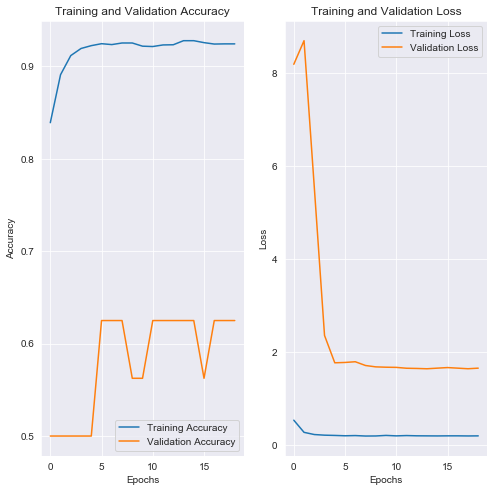

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(19), acc, label='Training Accuracy')
plt.plot(range(19), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.subplot(1, 2, 2)
plt.plot(range(19), loss, label='Training Loss')
plt.plot(range(19), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

### Run prediction on a sample image

first image to predict
actual label: PNEUMONIA
predicted label: NORMAL


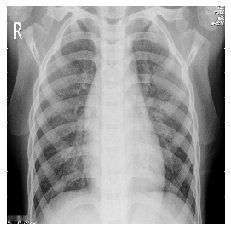

In [39]:
for images_batch, labels_batch in test_ds_1.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("actual label:",class_names[first_label])
    
    batch_prediction = saved_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Inference Function

In [40]:
def predict(saved_model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = saved_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#### Run inference on few sample images

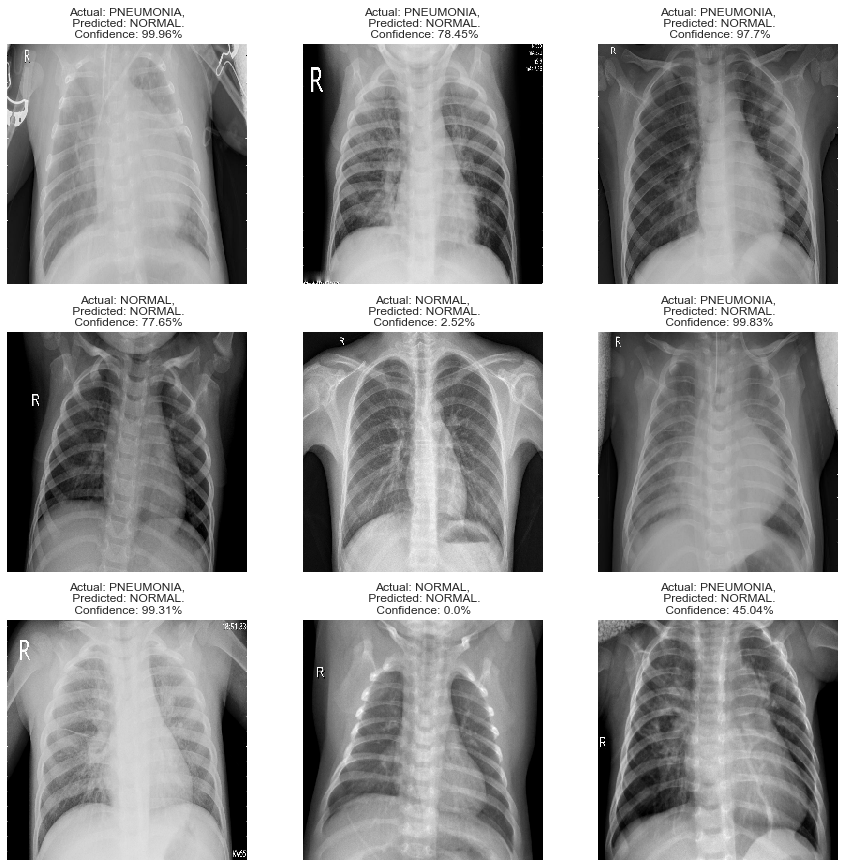

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds_1.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(saved_model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Other Model Evaluation Metrics

In [42]:
predictions = saved_model.predict(test_ds_1,verbose=0)

In [43]:
actual_test_labels = []
for x, y in test_ds_1:
  for i in y.numpy():
    actual_test_labels.append(i)

In [44]:
actual_test_labels

[0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,


In [45]:
len(actual_test_labels)

624

In [46]:
actual_test_labels= np.array([actual_test_labels])

In [47]:
actual_test_labels

array([[0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 

In [48]:
actual_test_labels.shape

(1, 624)

In [49]:
actual_test_labels = actual_test_labels.transpose()

In [50]:
actual_test_labels.shape

(624, 1)

In [51]:
predicted_labels = predictions.round()

In [52]:
predicted_labels.shape

(624, 1)

Confusion matrix, without normalization
[[ 99 135]
 [181 209]]


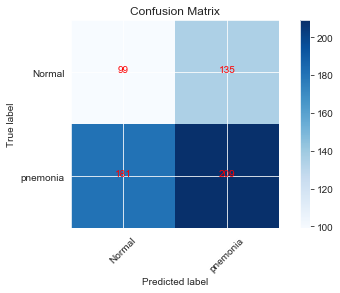

In [53]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="red")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure()

true = actual_test_labels
pred = predicted_labels
cm = confusion_matrix(true, pred)


plot_confusion_matrix(cm, classes=['Normal','pnemonia'], normalize=False,
                      title='Confusion Matrix')
plt.show()

Okay, this is terrible

In [54]:
#calculate the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(true, pred)
roc_auc = auc(fpr, tpr)

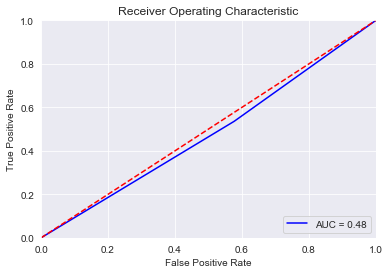

In [55]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [56]:
print(classification_report(true, pred,target_names=['Normal','pnemonia']))

              precision    recall  f1-score   support

      Normal       0.35      0.42      0.39       234
    pnemonia       0.61      0.54      0.57       390

    accuracy                           0.49       624
   macro avg       0.48      0.48      0.48       624
weighted avg       0.51      0.49      0.50       624



Based on this classification report and training accuracy,this model is overfiting. We cannot rely on testing accuracy or accuracy alone as our evaluation metric because our classes are imbalanced which could be a factor in this model's performance. Even with all the preprocessing steps (Data Augementation, Regularization and Normalization) implemented we still ended up here. Therefore instead of handling the imbalance and constantly re training this model. Let us try a different approach altogether without using tf.data.Dataset. There might be something i am missing and not being able to catch it right away.

### Export / Save The Final Model

In [57]:
model.save("./pneumonia_prediction_final_model.h5")